In [1]:
from fastai.vision.all import *
from fastai.data.all import *

/home/jono/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Data access
Functions describing the layout of vimeo image triples data.

In [14]:
def get_file_names(path="vimeo_interp_test/target"):
    """ Gets vimeo dataset file name templates. These do not have the "1.png" type suffix.
        For input features 1.png and 3.png should be added.
        For output features 2.png suffix should be added.
    """
    for d in os.listdir(path):
        for sd in os.listdir(path+os.sep+d):
          # Each of these sub-directories will contain the three images
          yield path+os.sep+d+os.sep+sd+os.sep+"im" # always names im3.png etc.
            
def get_output_file(template_name):
    return template_name+"2.png"

def get_input_files(template_name):
    return (template_name+"1.png",template_name+"3.png")

### Item representation
We'll work with 3-tuples of image tensors.
Extend the tuple with a show function.

In [3]:

class ImageTrio(tuple):
    def show(self, ctx=None, **kwargs):
        return show_image(torch.cat([self[0],self[2],self[1]],dim=2), figsize=(12,4), title="", ctx=ctx)
    
    def create(self,x):
        return self(x)



## Data loading pipeline
The transforms to go from the file data (defined in first section) to representation (from second section).

In [4]:
    
def build_image_paths(file_template:str):
    return get_input_files(file_template) + (get_output_file(file_template),)
    
def img_to_tensor(x):
    return TensorImage( tensor(array(x)).permute(2,0,1).float()/255. )

def load_image(filename:str):
    """ Transforms a filename into an image tensor """
    x = Image.open(filename).convert('RGB')
    return img_to_tensor(x)

class MakeImageTrio(ItemTransform): # ItemTransform so it applies to the tuple as a whole
    """ Transforms a 3-tuple into an ImageTriple (adds functions)"""
    def encodes(self, x):
        return ImageTrio(x)


In [5]:
pipe = Pipeline([ build_image_paths, load_image , MakeImageTrio() ])

input_path = "/media/jono/Data/workspace/data/vimeo_interp_test/target"
filenames = list(get_file_names(input_path))

# possible splits
splits = RandomSplitter(seed=1010)(filenames)
data_list = TfmdLists(filenames, pipe, splits=splits)

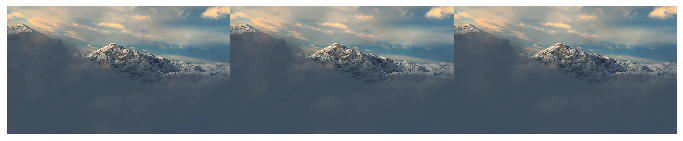

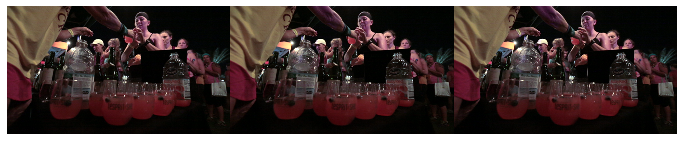

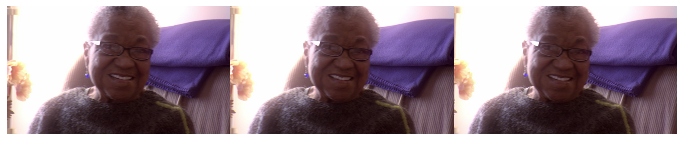

In [6]:
data_list[0].show()
data_list.train[0].show()
data_list.valid[0].show()

## Batching and augmentation

In [7]:
  
class VerticalFlip(RandTransform):
    def __init__(self, p=0.5,split_idx=None): 
        super().__init__(p=p)
        self.split_idx=split_idx
        
    def encodes(self, x): 
        return x.flip(-2)
    
class ReverseTrio(ItemTransform):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
        self.split_index=0
        
    def encodes(self, x):
        #TODO: x is a batch. Need to swap all in the batch
        print(x.shape)
        return (x[1],x[0],x[2])
    
# Transform first two elements into 6-channel matrix
class CombineImages(ItemTransform):
    def __init__(self):
        super().__init__()
        self.split_idx=None
        
    def encodes(self,x):
        # x is [image][batch index][channel][x][y]
        # we want to concatenate the first two images of each batch index in their channel dimension
        old_imgs = x[1]
        batch_size = x[0].shape[0]
        new_imgs = torch.zeros( (batch_size,6,x[0].shape[2],x[0].shape[3]) )
        for i in range(batch_size):
            new_imgs[i,0:3,:,:] = old_imgs[i]
            new_imgs[i,3:6,:,:] = x[0][i]
        return (new_imgs,x[2])
    
flipper = Flip(p=0.5)
flipper.split_idx = 0 # training data only
augmentations = [flipper,VerticalFlip(p=0.5,split_idx=0),CombineImages()]
d_loader = data_list.dataloaders(bs=8, shuffle=False,after_batch=augmentations)

Batch visualisation. The tensors are now first indexed by the two image tensors, then the batch size.

But let's first make a new tuple extension to visualising the 6-channel images as two 3-channel ones again.

In [8]:
class PairImage(tuple):
    def show(self, ctx=None, **kwargs):
        return show_image(torch.cat([self[0][0:3],self[0][3:6],self[1]],dim=2), figsize=(12,4), title="", ctx=ctx)
    
    def create(self,x):
        return self(x)

def show_batch(x, y, samples, ctxs=None, max_n=6, nrows=None, ncols=3, figsize=None, **kwargs):
    if ctxs is None: 
        ctxs = get_grid(min(len(x[0]), max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        PairImage( (x[0][i], x[1][i]) ).show(ctx=ctx)

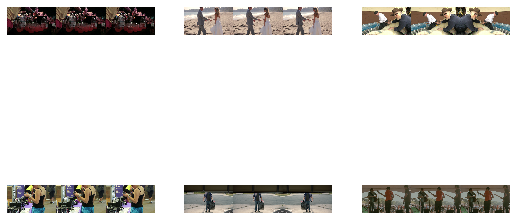

In [9]:
ex_batch = d_loader.train.one_batch()
show_batch(ex_batch,0,0)

This data loader is sufficient to run the learning rate finder.

## Model

Load custom model: fully convolutional u-net with 2x input channels.

In [10]:
import unet_model
m = unet_model.InterpolationUNet()

In [11]:
learn = Learner(d_loader, m, MSELossFlat())

Quick test that everything is working, then we'll be ready for finding a suitable learning rate and starting training.

In [12]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.040428,0.012177,43:28


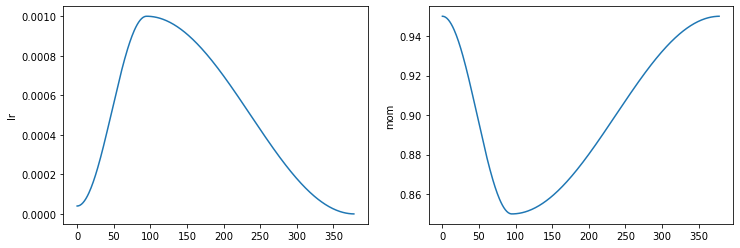

In [13]:
learn.recorder.plot_sched()